In [1]:
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()

In [2]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    data=[]
    for label in labels:
#         train/PNEUMONIA
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = "C:/Users/Surface/Desktop/Deep Learning/chest_xray/chest_xray/train"
test = "C:/Users/Surface/Desktop/Deep Learning/chest_xray/chest_xray/test"
val = "C:/Users/Surface/Desktop/Deep Learning/chest_xray/chest_xray/val"

In [8]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/train/PNEUMONIA"

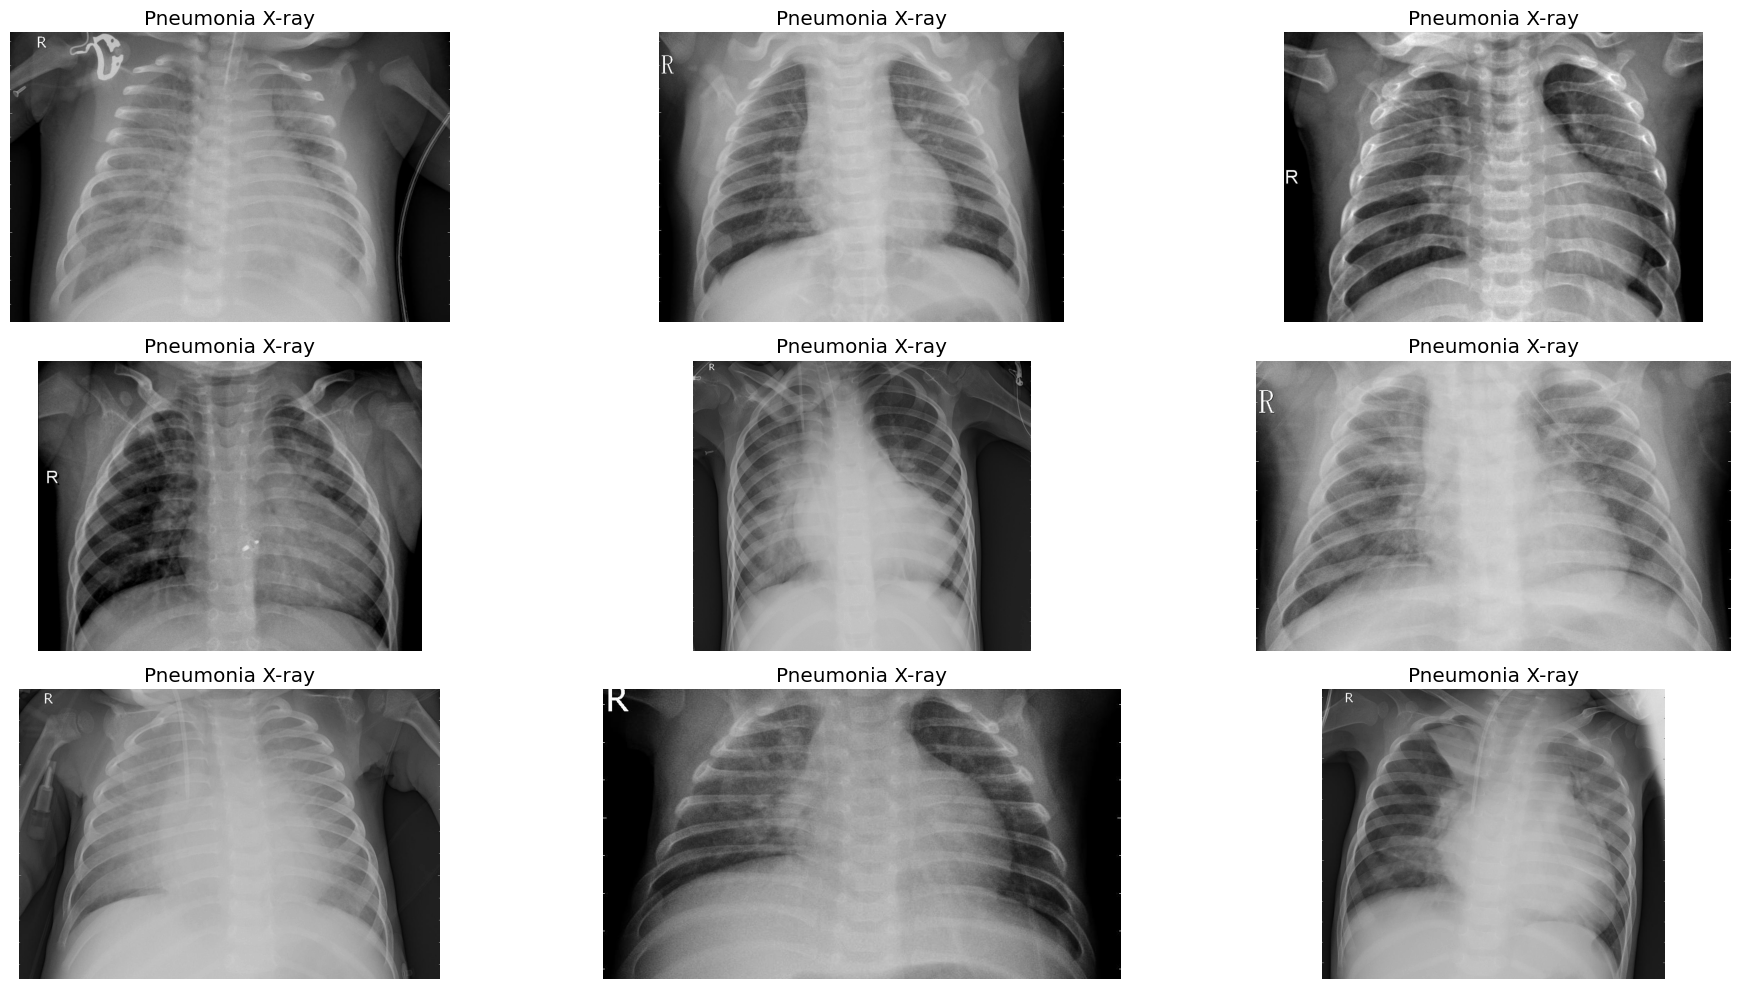

In [9]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [10]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

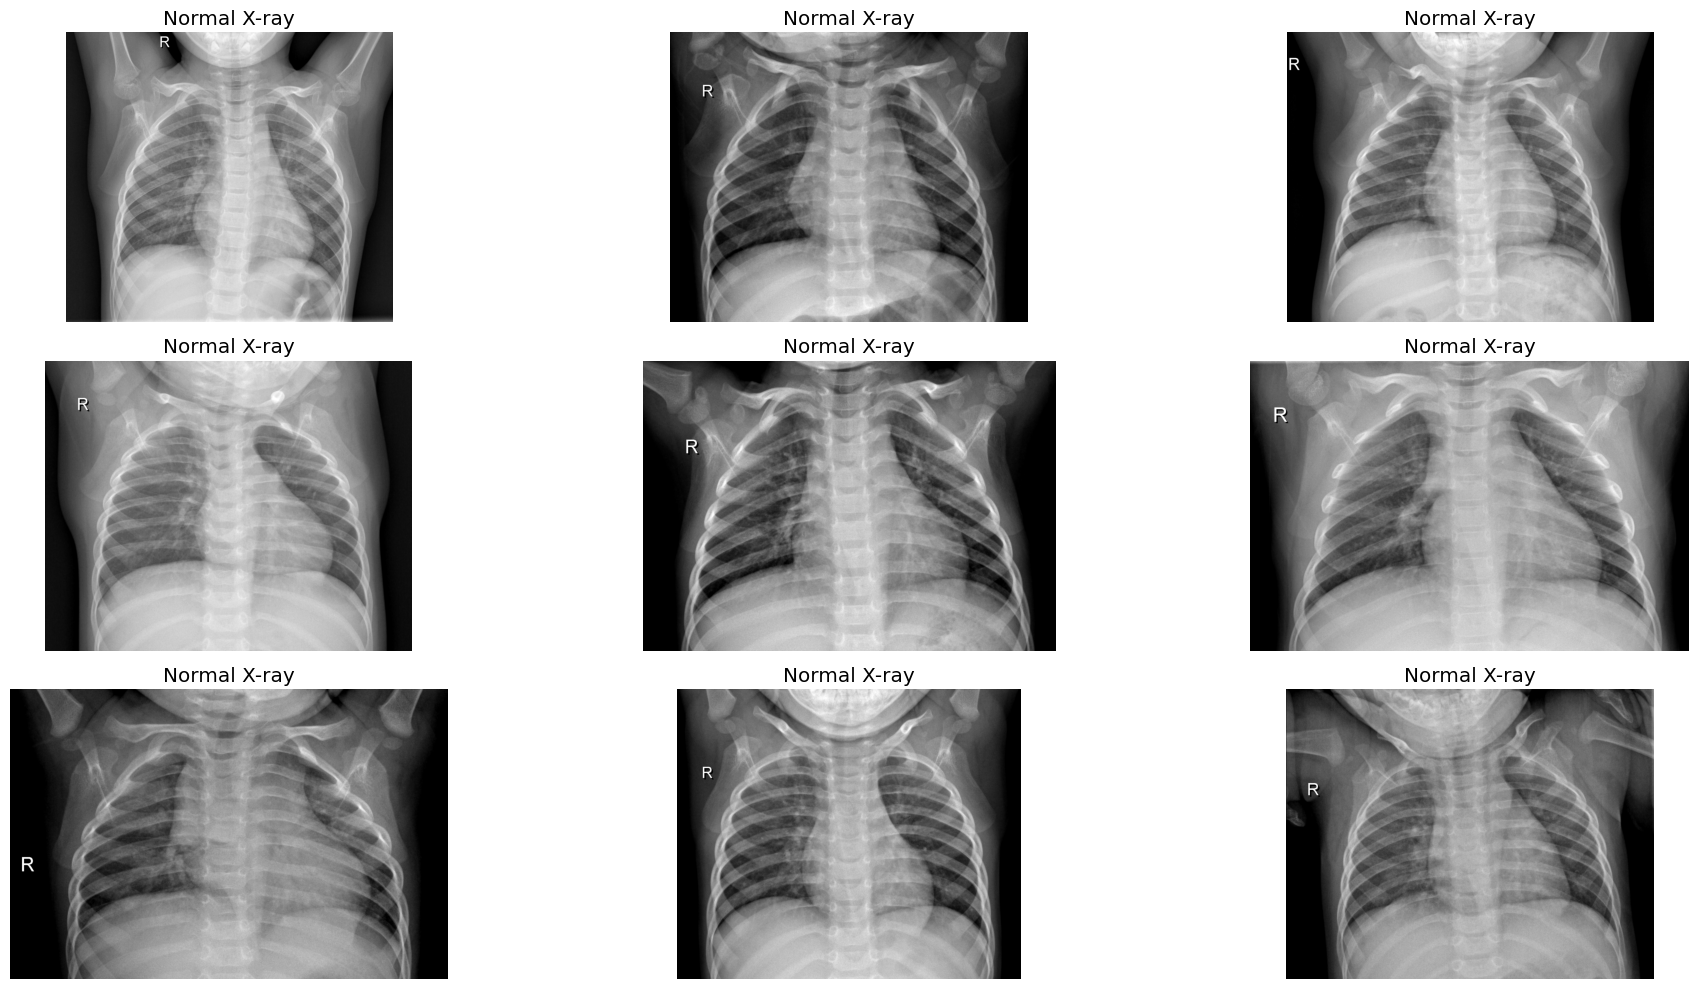

In [11]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

d:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel='count'>

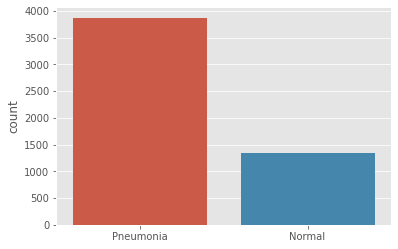

In [8]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [12]:
# Data Augmentation & Resizing

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [14]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [16]:
class_labels = train_generator.class_indices

In [17]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [18]:
class_name = {value:key for (key, value) in class_labels.items()}

In [19]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [20]:
# VGG19 CNN Architecture

In [21]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [27]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Use SGD with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [28]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=50,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

50/50 [==============================] - 161s 3s/step - loss: 0.6249 - accuracy: 0.7175 - val_loss: 0.8278 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [29]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [30]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [31]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

20/20 [==============================] - 57s 3s/step - loss: 0.7044 - accuracy: 0.6250


In [32]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.8277614116668701
Validation Accuarcy: 0.5
Test Loss: 0.7043600082397461
Test Accuarcy: 0.625


In [33]:
# Increamental unfreezing & fine tuning

In [34]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [35]:
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [37]:
from tensorflow.keras.optimizers.legacy import SGD

# Définir l'optimiseur avec decay
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0, nesterov=True)

# Compiler le modèle
model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


In [38]:
history_02 = model_02.fit(train_generator, 
            steps_per_epoch=10,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

10/10 [==============================] - 118s 12s/step - loss: 0.6011 - accuracy: 0.7250 - val_loss: 0.8348 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [39]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [40]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

20/20 [==============================] - 54s 3s/step - loss: 0.7069 - accuracy: 0.6250
Validation Loss: 0.8347705602645874
Validation Accuarcy: 0.5
Test Loss: 0.7069212198257446
Test Accuarcy: 0.625


In [41]:
# Unfreezing and fine tuning the entire network

In [42]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [43]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [44]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

100/100 [==============================] - 1237s 12s/step - loss: 0.5626 - accuracy: 0.7369 - val_loss: 0.7673 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [45]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)